In [689]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from mizani.formatters import percent_format
from plotnine import *

pd.set_option('display.max_row',None)

In [690]:
# read and drop non-important columns
data = pd.read_csv('paris.csv')
trivial = ['listing_url','scrape_id','last_scraped','source','name','description','picture_url','host_id','host_url','host_name','host_location','host_thumbnail_url','host_picture_url','host_neighbourhood','neighbourhood','neighbourhood_group_cleansed','amenities','minimum_minimum_nights','maximum_minimum_nights','host_verifications','maximum_nights','first_review','last_review','bedrooms','bathrooms',
'minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','calendar_updated','has_availability','calendar_last_scraped','license']
data.drop(trivial,axis = 1,inplace = True)
data.set_index('id',inplace=True)


# data cleaning: price, transfer from str to float
data.dropna(subset=["price"],inplace=True)
data["price"] = data["price"].str.replace(",", "")
data["price"] = data["price"].str.replace("$", "").astype("float")

# remove extreme values (3 sigma principle)
priceH = data.price.mean()+3*data.price.std()
priceL = data.price.mean()-3*data.price.std()
data = data.loc[(data.price < priceH) & (data.price > priceL) ]
data.price.describe()

count    66704.000000
mean       190.584508
std        216.168587
min          8.000000
25%         86.000000
50%        128.000000
75%        200.000000
max       2201.000000
Name: price, dtype: float64

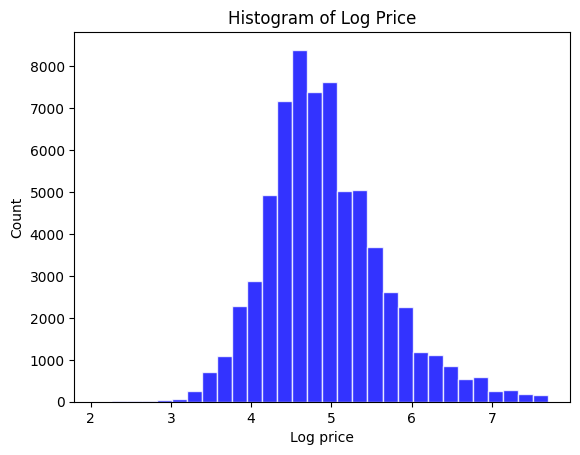

In [691]:
# calculate log price
data["ln_price"] = np.log(data.price)

# plot histogram
plt.hist(data['ln_price'], bins=30, color='blue', edgecolor='white', alpha=0.8)
plt.xlabel('Log price')
plt.ylabel('Count')
plt.title('Histogram of Log Price')
plt.show()

In [692]:
data.room_type = ['entire' if x == "Entire home/apt" else "private" for x in data.room_type]
data["room_type"] = data["room_type"].astype("category")
data.room_type.value_counts()
data.room_type = data.room_type.cat.codes
print(data.head())
 
# Convert room_type into dummy variables

# Convert room_type into dummy variables
dummy_variables = pd.get_dummies(data['room_type'], prefix='room_type_private', drop_first=True)

# Concatenate the original dataset with the dummy variables
data = pd.concat([data, dummy_variables], axis=1)
print(data.head())
#using appartment as the base category
smf.ols('ln_price~ room_type_private_1', data=data).fit().summary()

                                   neighborhood_overview  host_since  \
id                                                                     
3109   Good restaurants<br />very close the Montparna...  2008-10-14   
5396   You are within walking distance to the Louvre,...  2009-02-14   
81106  The neighborhood will show you an other side o...  2011-03-13   
7397                                                 NaN  2008-08-30   
7964                                                 NaN  2009-06-18   

                                              host_about  host_response_time  \
id                                                                             
3109                                                 NaN  within a few hours   
5396   We have spent a lot of time traveling for work...      within an hour   
81106  Independent photographer. \nCyclist. Often on ...  within a few hours   
7397   I am a writer,54, author of novels, books of l...      within an hour   
7964   Hello ! 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     2138.
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:08:42   Log-Likelihood:                -72338.
No. Observations:               66704   AIC:                         1.447e+05
Df Residuals:                   66702   BIC:                         1.447e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       4.9812      0.003   1682.338      0.000       4.975       4.987
room_type_private_1[T.True]    -0.3888      0.008    -46.243      0.000      -0.405      -0.372
==============================================================================
Omnibus:                     6624.081   Durbin-Watson:                   1.818
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9522.361
Skew:                           0.779   Prob(JB):                         0.00
Kurtosis:                       4.001   Cond. No.                         3.09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

neighbourhood_cleansed
Buttes-Montmartre      7385
Popincourt             5934
Vaugirard              4995
Entrepôt               4726
Batignolles-Monceau    4484
Passy                  4006
Buttes-Chaumont        3864
Ménilmontant           3699
Opéra                  3293
Temple                 2949
Reuilly                2633
Observatoire           2458
Bourse                 2361
Hôtel-de-Ville         2190
Élysée                 2143
Gobelins               2127
Panthéon               2123
Luxembourg             1933
Palais-Bourbon         1850
Louvre                 1551
Name: count, dtype: int64


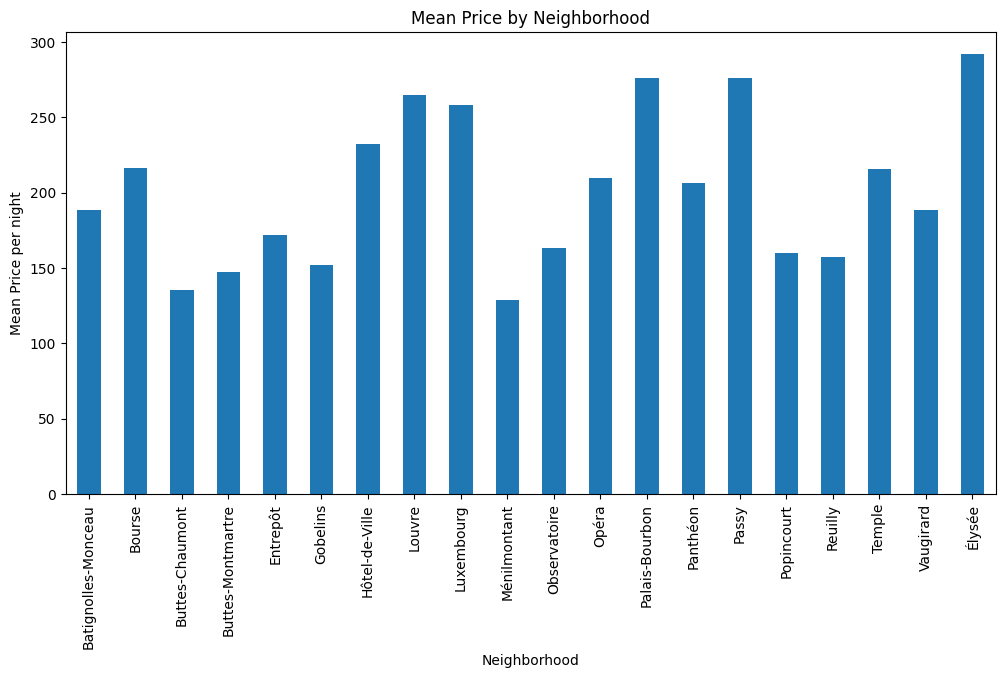

Index(['neighborhood_overview', 'host_since', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms_text', 'beds', 'price',
       'minimum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calc

In [693]:
# Group dataset by neighborhood
grouped = data.groupby('neighbourhood_cleansed')
print(data.neighbourhood_cleansed.value_counts())
#most os observations are in "commune de geneve" so we will use it as the base category
# Calculate the mean price for each neighborhood
mean_price = grouped['price'].mean()

# Plot the mean prices
plt.figure(figsize=(12, 6))
mean_price.plot(kind='bar')
plt.xlabel('Neighborhood')
plt.ylabel('Mean Price per night')
plt.title('Mean Price by Neighborhood')
plt.show()
#understand differences in price by neighborhood by doing a linear regression using the categpry with more observations as the base category
dummy_neigh = pd.get_dummies(data['neighbourhood_cleansed'], prefix='neighbourhood', drop_first=True)

# Concatenate the original dataset with the dummy variables
data = pd.concat([data, dummy_neigh], axis=1)

print(data.columns)

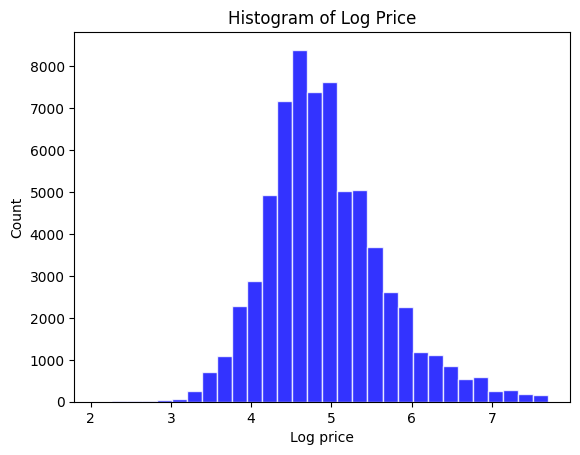

In [694]:
# calculate log price
data["ln_price"] = np.log(data.price)

# plot histogram
plt.hist(data['ln_price'], bins=30, color='blue', edgecolor='white', alpha=0.8)
plt.xlabel('Log price')
plt.ylabel('Count')
plt.title('Histogram of Log Price')
plt.show()

In [695]:
data.room_type.value_counts()

room_type
0    58433
1     8271
Name: count, dtype: int64

In [696]:
# data['room_type'] = data[(data['room_type'] == "Entire home/apt") or  (data['room_type'] == "Private room ")]
# data.room_type = ['entire' if x == "Entire home/apt" else "private" for x in data.room_type]
# data["room_type"] = data["room_type"].astype("category")

# data.room_type.value_counts()

In [697]:
smf.ols(formula="ln_price ~ room_type", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     2138.
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:08:43   Log-Likelihood:                -72338.
No. Observations:               66704   AIC:                         1.447e+05
Df Residuals:                   66702   BIC:                         1.447e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.9812      0.003   1682.338      0.000       4.975       4.987
room_type     -0.3888      0.008    -46.243      0.000      -0.405      -0.372
==============================================================================
Omnibus:                     6624.081   Durbin-Watson:                   1.818
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9522.361
Skew:                           0.779   Prob(JB):                         0.00
Kurtosis:                       4.001   Cond. No.                         3.09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [698]:
data.beds.value_counts()

beds
1.0     35165
2.0     19656
3.0      6764
4.0      2818
5.0      1005
6.0       391
7.0       132
8.0        80
9.0        29
11.0        8
10.0        8
12.0        7
13.0        4
18.0        2
15.0        2
79.0        1
77.0        1
85.0        1
90.0        1
83.0        1
17.0        1
Name: count, dtype: int64

In [699]:
data.loc[data['beds']>10,'beds'] = 10 # winsorize extreme value
data.beds.describe()

count    66077.000000
mean         1.749580
std          1.060602
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         10.000000
Name: beds, dtype: float64

In [700]:
smf.ols(formula="ln_price ~ beds", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                 1.818e+04
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:08:43   Log-Likelihood:                -64510.
No. Observations:               66077   AIC:                         1.290e+05
Df Residuals:                   66075   BIC:                         1.290e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3780      0.005    908.210      0.000       4.369       4.387
beds           0.3177      0.002    134.832      0.000       0.313       0.322
==============================================================================
Omnibus:                     5389.353   Durbin-Watson:                   1.800
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10572.823
Skew:                           0.560   Prob(JB):                         0.00
Kurtosis:                       4.608   Cond. No.                         4.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [701]:
data.bathrooms_text.value_counts()

bathrooms_text
1 bath               48887
1.5 baths             4815
2 baths               4268
1 private bath        2913
1 shared bath         2838
2.5 baths             1031
3 baths                639
1.5 shared baths       362
Half-bath              244
3.5 baths              169
4 baths                106
0 baths                 99
2 shared baths          59
4.5 baths               42
Shared half-bath        36
0 shared baths          33
5 baths                 21
Private half-bath       20
2.5 shared baths        11
6 baths                 11
5.5 baths                6
3 shared baths           6
7 baths                  4
48 baths                 4
6.5 baths                3
49 baths                 2
7.5 baths                2
3.5 shared baths         2
6 shared baths           1
47 baths                 1
4 shared baths           1
10 baths                 1
5.5 shared baths         1
8.5 baths                1
Name: count, dtype: int64

In [702]:
# transfer into numerical
tmp = data.bathrooms_text
tmp = tmp.replace({'Shared half-bath':0.5, 'Half-bath':0.5})
tmp = tmp.str.extractall(r'(\d+(?:\.\d+)?)')
tmp.columns =['n_bath']
tmp = tmp.reset_index(level=1).drop('match',axis=1)
data = data.merge(tmp,left_index=True,right_index=True,how = 'outer', validate='one_to_one')
data.n_bath = data.n_bath.astype('float')
data.n_bath.value_counts().sort_index()

n_bath
0.0       132
1.0     54638
1.5      5177
2.0      4327
2.5      1042
3.0       645
3.5       171
4.0       107
4.5        42
5.0        21
5.5         7
6.0        12
6.5         3
7.0         4
7.5         2
8.5         1
10.0        1
47.0        1
48.0        4
49.0        2
Name: count, dtype: int64

In [703]:
data.loc[data['n_bath']>10,'n_bath'] = 10 # winsorize extreme value
data.n_bath.describe()

count    66339.000000
mean         1.163411
std          0.446981
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         10.000000
Name: n_bath, dtype: float64

In [704]:
smf.ols(formula="ln_price ~ n_bath", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                 1.447e+04
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:08:45   Log-Likelihood:                -66262.
No. Observations:               66339   AIC:                         1.325e+05
Df Residuals:                   66337   BIC:                         1.325e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1364      0.007    581.573      0.000       4.122       4.150
n_bath         0.6864      0.006    120.275      0.000       0.675       0.698
==============================================================================
Omnibus:                     5036.568   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14698.716
Skew:                           0.408   Prob(JB):                         0.00
Kurtosis:                       5.157   Cond. No.                         5.53
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [705]:
data.review_scores_rating.describe()

count    52469.000000
mean         4.695010
std          0.426015
min          0.000000
25%          4.580000
50%          4.820000
75%          5.000000
max          5.000000
Name: review_scores_rating, dtype: float64

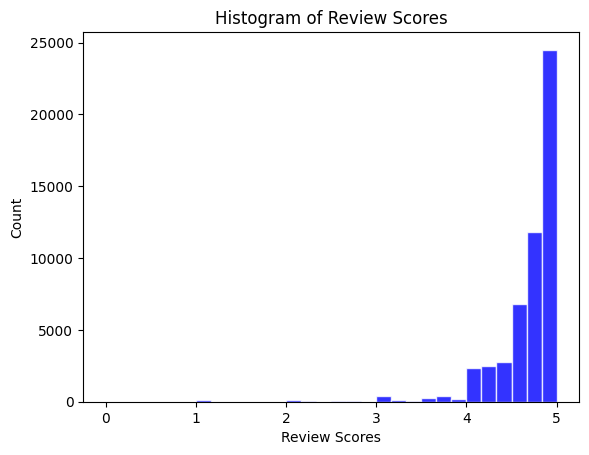

In [706]:
# plot histogram
plt.hist(data['review_scores_rating'], bins=30, color='blue', edgecolor='white', alpha=0.8)
plt.xlabel('Review Scores')
plt.ylabel('Count')
plt.title('Histogram of Review Scores')
plt.show()

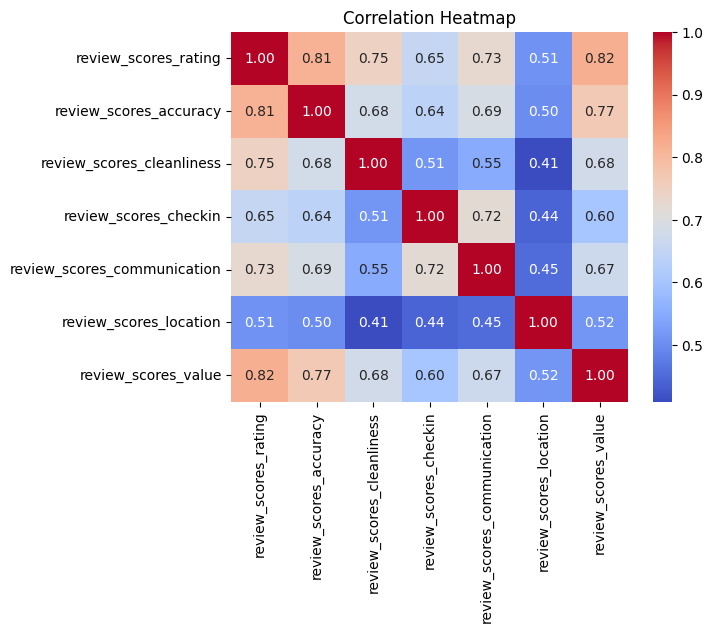

In [707]:
rscores = data.loc[:,[x for x in data.columns if 'review_scores' in x]]
correlation_matrix = rscores.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [708]:
smf.ols(formula="ln_price ~ review_scores_rating", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     607.3
Date:                Sun, 03 Mar 2024   Prob (F-statistic):          2.45e-133
Time:                        21:08:47   Log-Likelihood:                -52320.
No. Observations:               52469   AIC:                         1.046e+05
Df Residuals:                   52467   BIC:                         1.047e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                4.1044      0.032    129.532      0.000       4.042       4.167
review_scores_rating     0.1656      0.007     24.644      0.000       0.152       0.179
==============================================================================
Omnibus:                     3279.211   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4615.266
Skew:                           0.553   Prob(JB):                         0.00
Kurtosis:                       3.941   Cond. No.                         54.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [709]:
smf.ols(formula="ln_price ~ review_scores_location", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1022.
Date:                Sun, 03 Mar 2024   Prob (F-statistic):          4.57e-222
Time:                        21:08:47   Log-Likelihood:                -52091.
No. Observations:               52454   AIC:                         1.042e+05
Df Residuals:                   52452   BIC:                         1.042e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3.5400      0.042     84.117      0.000       3.458       3.623
review_scores_location     0.2794      0.009     31.965      0.000       0.262       0.297
==============================================================================
Omnibus:                     3312.147   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4716.866
Skew:                           0.553   Prob(JB):                         0.00
Kurtosis:                       3.966   Cond. No.                         74.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [710]:
data.minimum_nights.describe()

count    66704.000000
mean        42.671669
std        108.695509
min          1.000000
25%          2.000000
50%          3.000000
75%          6.000000
max       1000.000000
Name: minimum_nights, dtype: float64

In [711]:
minimum_nightsH = data.minimum_nights.mean()+3*data.minimum_nights.std()
minimum_nightsL = data.minimum_nights.mean()-3*data.minimum_nights.std()
data = data.loc[(data.minimum_nights < minimum_nightsH) & (data.minimum_nights > minimum_nightsL) ]
data.minimum_nights.describe()

count    66679.000000
mean        42.453771
std        108.025480
min          1.000000
25%          2.000000
50%          3.000000
75%          6.000000
max        366.000000
Name: minimum_nights, dtype: float64

In [712]:
smf.ols(formula="ln_price ~ minimum_nights", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     3996.
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:08:47   Log-Likelihood:                -71424.
No. Observations:               66679   AIC:                         1.429e+05
Df Residuals:                   66677   BIC:                         1.429e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          5.0010      0.003   1701.755      0.000       4.995       5.007
minimum_nights    -0.0016   2.53e-05    -63.215      0.000      -0.002      -0.002
==============================================================================
Omnibus:                     5863.874   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8739.776
Skew:                           0.691   Prob(JB):                         0.00
Kurtosis:                       4.113   Cond. No.                         125.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [713]:
data.host_is_superhost.value_counts()

host_is_superhost
f    55099
t    11495
Name: count, dtype: int64

In [714]:
smf.ols(formula="ln_price ~ host_is_superhost", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     536.0
Date:                Sun, 03 Mar 2024   Prob (F-statistic):          4.17e-118
Time:                        21:08:47   Log-Likelihood:                -73008.
No. Observations:               66594   AIC:                         1.460e+05
Df Residuals:                   66592   BIC:                         1.460e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  4.9037      0.003   1589.280      0.000       4.898       4.910
host_is_superhost[T.t]     0.1719      0.007     23.151      0.000       0.157       0.186
==============================================================================
Omnibus:                     5834.849   Durbin-Watson:                   1.779
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8334.338
Skew:                           0.707   Prob(JB):                         0.00
Kurtosis:                       4.001   Cond. No.                         2.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [715]:
data.accommodates.describe()

count    66679.000000
mean         3.137405
std          1.630047
min          1.000000
25%          2.000000
50%          2.000000
75%          4.000000
max         16.000000
Name: accommodates, dtype: float64

In [716]:
smf.ols(formula="ln_price ~ accommodates", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                 2.575e+04
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:08:48   Log-Likelihood:                -62478.
No. Observations:               66679   AIC:                         1.250e+05
Df Residuals:                   66677   BIC:                         1.250e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.1944      0.005    808.534      0.000       4.184       4.205
accommodates     0.2354      0.001    160.459      0.000       0.233       0.238
==============================================================================
Omnibus:                     6598.438   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12302.307
Skew:                           0.674   Prob(JB):                         0.00
Kurtosis:                       4.617   Cond. No.                         8.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [717]:
data['ln_accommodates'] = np.log(data['accommodates'])
smf.ols(formula="ln_price ~ ln_accommodates+accommodates", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                 1.351e+04
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:08:48   Log-Likelihood:                -62023.
No. Observations:               66679   AIC:                         1.241e+05
Df Residuals:                   66676   BIC:                         1.241e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.1128      0.006    707.467      0.000       4.101       4.124
ln_accommodates     0.4974      0.016     30.294      0.000       0.465       0.530
accommodates        0.0984      0.005     20.712      0.000       0.089       0.108
==============================================================================
Omnibus:                     6831.164   Durbin-Watson:                   1.752
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12501.330
Skew:                           0.699   Prob(JB):                         0.00
Kurtosis:                       4.595   Cond. No.                         27.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [718]:
data.number_of_reviews.describe()

count    66679.000000
mean        24.812055
std         57.090194
min          0.000000
25%          1.000000
50%          7.000000
75%         24.000000
max       2636.000000
Name: number_of_reviews, dtype: float64

In [719]:
smf.ols(formula="ln_price ~ number_of_reviews", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     8.695
Date:                Sun, 03 Mar 2024   Prob (F-statistic):            0.00319
Time:                        21:08:48   Log-Likelihood:                -73360.
No. Observations:               66679   AIC:                         1.467e+05
Df Residuals:                   66677   BIC:                         1.467e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.9367      0.003   1607.974      0.000       4.931       4.943
number_of_reviews    -0.0001   4.93e-05     -2.949      0.003      -0.000   -4.88e-05
==============================================================================
Omnibus:                     5399.619   Durbin-Watson:                   1.782
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7515.442
Skew:                           0.677   Prob(JB):                         0.00
Kurtosis:                       3.933   Cond. No.                         67.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [720]:
data['ln_number_of_reviews'] = np.log(data['number_of_reviews']+1e-10 )  # +1e-10 to avoid -inf
data.ln_number_of_reviews.describe()

count    6.667900e+04
mean    -3.027655e+00
std      1.053671e+01
min     -2.302585e+01
25%      1.000000e-10
50%      1.945910e+00
75%      3.178054e+00
max      7.877018e+00
Name: ln_number_of_reviews, dtype: float64

In [721]:
smf.ols(formula="ln_price ~ ln_number_of_reviews+number_of_reviews", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     564.6
Date:                Sun, 03 Mar 2024   Prob (F-statistic):          7.23e-244
Time:                        21:08:48   Log-Likelihood:                -72805.
No. Observations:               66679   AIC:                         1.456e+05
Df Residuals:                   66676   BIC:                         1.456e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                4.8955      0.003   1490.656      0.000       4.889       4.902
ln_number_of_reviews    -0.0093      0.000    -33.471      0.000      -0.010      -0.009
number_of_reviews        0.0004   5.14e-05      7.373      0.000       0.000       0.000
==============================================================================
Omnibus:                     4100.515   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5382.327
Skew:                           0.575   Prob(JB):                         0.00
Kurtosis:                       3.783   Cond. No.                         73.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## model selection

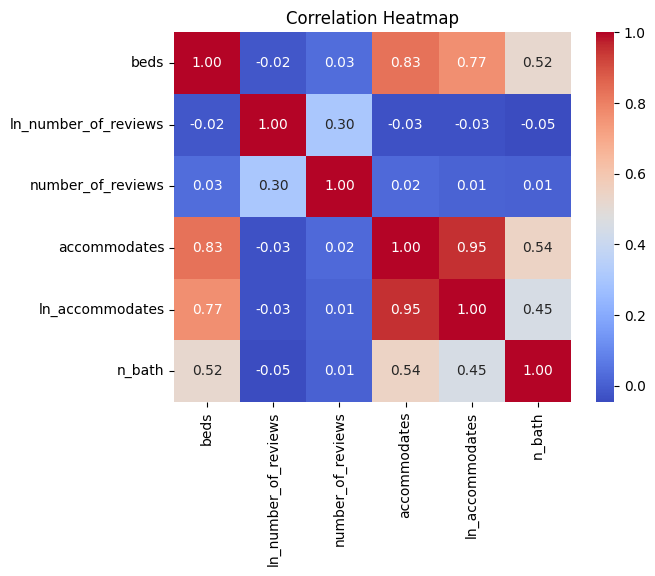

In [722]:
factors = data.loc[:,['beds','ln_number_of_reviews','number_of_reviews','accommodates','ln_accommodates','n_bath']]
correlation_matrix = factors.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


In [723]:
smf.ols(formula="ln_price ~ room_type_private_1+beds+ln_number_of_reviews+number_of_reviews+accommodates+ln_accommodates+n_bath+host_is_superhost", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     4461.
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:08:49   Log-Likelihood:                -57622.
No. Observations:               65617   AIC:                         1.153e+05
Df Residuals:                   65608   BIC:                         1.153e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       3.8000      0.008    468.973      0.000       3.784       3.816
room_type_private_1[T.True]    -0.1290      0.008    -17.146      0.000      -0.144      -0.114
host_is_superhost[T.t]          0.2103      0.006     33.612      0.000       0.198       0.223
beds                            0.0493      0.004     12.505      0.000       0.042       0.057
ln_number_of_reviews           -0.0087      0.000    -37.723      0.000      -0.009      -0.008
number_of_reviews            1.529e-05   4.37e-05      0.350      0.726   -7.03e-05       0.000
accommodates                   -0.0468      0.006     -8.236      0.000      -0.058      -0.036
ln_accommodates                 0.6974      0.017     40.941      0.000       0.664       0.731
n_bath                          0.3688      0.006     58.324      0.000       0.356       0.381
==============================================================================
Omnibus:                     6061.437   Durbin-Watson:                   1.774
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13514.054
Skew:                           0.582   Prob(JB):                         0.00
Kurtosis:                       4.894   Cond. No.                         502.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [724]:
smf.ols(formula="ln_price ~ room_type+beds+number_of_reviews+accommodates+ln_accommodates+n_bath+host_is_superhost", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     4791.
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:08:50   Log-Likelihood:                -58326.
No. Observations:               65617   AIC:                         1.167e+05
Df Residuals:                   65609   BIC:                         1.167e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3.8234      0.008    468.204      0.000       3.807       3.839
host_is_superhost[T.t]     0.1751      0.006     28.000      0.000       0.163       0.187
room_type                 -0.1138      0.008    -14.988      0.000      -0.129      -0.099
beds                       0.0480      0.004     12.054      0.000       0.040       0.056
number_of_reviews         -0.0004   4.24e-05    -10.353      0.000      -0.001      -0.000
accommodates              -0.0484      0.006     -8.414      0.000      -0.060      -0.037
ln_accommodates            0.7107      0.017     41.283      0.000       0.677       0.744
n_bath                     0.3787      0.006     59.303      0.000       0.366       0.391
==============================================================================
Omnibus:                     7578.701   Durbin-Watson:                   1.764
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17486.171
Skew:                           0.696   Prob(JB):                         0.00
Kurtosis:                       5.112   Cond. No.                         502.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [725]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Fit the OLS model
model = ols(formula="ln_price ~ room_type_private_1 + beds + ln_number_of_reviews + number_of_reviews + accommodates + ln_accommodates + n_bath + host_is_superhost", data=data)
results = model.fit()

# Print summary
print(results.summary())

# Perform the Breusch-Pagan test
breusch_pagan_test = sm.stats.diagnostic.het_breuschpagan(results.resid, results.model.exog)
print("Breusch-Pagan Test:")
print("Lagrange multiplier statistic:", breusch_pagan_test[0])
print("p-value:", breusch_pagan_test[1])
print("f-value:", breusch_pagan_test[2])
print("f p-value:", breusch_pagan_test[3])



                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     4461.
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:08:50   Log-Likelihood:                -57622.
No. Observations:               65617   AIC:                         1.153e+05
Df Residuals:                   65608   BIC:                         1.153e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [726]:
#Fit the OLS model
model = ols(formula="ln_price ~ room_type_private_1 + beds + ln_number_of_reviews + number_of_reviews + accommodates + ln_accommodates + n_bath", data=data)
results = model.fit()

# Print summary
print(results.summary())

# Perform the Breusch-Pagan test
breusch_pagan_test = sm.stats.diagnostic.het_breuschpagan(results.resid, results.model.exog)
print("Breusch-Pagan Test:")
print("Lagrange multiplier statistic:", breusch_pagan_test[0])
print("p-value:", breusch_pagan_test[1])
print("f-value:", breusch_pagan_test[2])
print("f p-value:", breusch_pagan_test[3])

                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     4862.
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:08:51   Log-Likelihood:                -58249.
No. Observations:               65700   AIC:                         1.165e+05
Df Residuals:                   65692   BIC:                         1.166e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [727]:
data['neighborhood_overview'] = (~data['neighborhood_overview'].isna()).astype(int)
data['host_about'] = (~data['host_about'].isna()).astype(int)
# Fit the OLS model
model = ols(formula="ln_price ~ room_type_private_1 + beds + ln_number_of_reviews + number_of_reviews + accommodates + ln_accommodates + n_bath + host_is_superhost + neighborhood_overview + host_about", data=data)
results = model.fit()

# Print summary
print(results.summary())

# Perform the Breusch-Pagan test
breusch_pagan_test = sm.stats.diagnostic.het_breuschpagan(results.resid, results.model.exog)
print("Breusch-Pagan Test:")
print("Lagrange multiplier statistic:", breusch_pagan_test[0])
print("p-value:", breusch_pagan_test[1])
print("f-value:", breusch_pagan_test[2])
print("f p-value:", breusch_pagan_test[3])


                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     3583.
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:08:51   Log-Likelihood:                -57575.
No. Observations:               65617   AIC:                         1.152e+05
Df Residuals:                   65606   BIC:                         1.153e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [728]:
model = ols(formula="ln_price ~ room_type_private_1 + beds + ln_number_of_reviews  + accommodates + ln_accommodates + n_bath + host_is_superhost + host_about", data=data)
results = model.fit()

# Print summary
print(results.summary())

# Perform the Breusch-Pagan test
breusch_pagan_test = sm.stats.diagnostic.het_breuschpagan(results.resid, results.model.exog)
print("Breusch-Pagan Test:")
print("Lagrange multiplier statistic:", breusch_pagan_test[0])
print("p-value:", breusch_pagan_test[1])
print("f-value:", breusch_pagan_test[2])
print("f p-value:", breusch_pagan_test[3])
'''
predicted_prices = results.predict()
print(len(predicted_prices))
data=data.assign(predicted_prices = predicted_prices)

# Extract real prices from the original data

# Plot predicted prices vs. real prices
plt.figure(figsize=(10, 6))
plt.scatter(real_prices, predicted_prices, alpha=0.5)
plt.title('Predicted Prices vs. Real Prices')
plt.xlabel('Real Prices (ln)')
plt.ylabel('Predicted Prices (ln)')
plt.grid(True)
plt.show()

# I Tried to plot predicted vs real but I got an error, I dont know why vectors have different lenghts
'''
from statsmodels.stats.api import linear_reset
# Perform the RESET test
reset_test = linear_reset(results)
print("RESET test p-value:", reset_test.pvalue)
# reject the null hypothesis that the model is correctly specified #we need to look for interactions or non-linear relationships


                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     4479.
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:08:52   Log-Likelihood:                -57577.
No. Observations:               65617   AIC:                         1.152e+05
Df Residuals:                   65608   BIC:                         1.153e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [729]:
#look for interaction
